# Clustering Neighborhoods in Toronto

### ***Notes for whoever is reviewing this assignment:
I'm going to include all sections in the same notebook, both the instructions and my work.

Also, it is my understanding that the resulting tables don't need to be in the same order as the example screenshot, meaning if we follow the method from the lab for Section 3 and use the first neighborhood on the list, it might be different depending on how the table is ordered. This will therefore affect all following maps/tables, since a different neighborhood is being used.

Partial screen captures of maps are included, as I've been told the maps might not appear in Github.

In order to avoid including the FourSquare credentials in a public Github repository, I will be replacing them with 'REDACTED'.

## ---------- Section 1, Instructions ----------

For this assignment, you will be required to explore and cluster the neighborhoods in Toronto.

1. Start by creating a new Notebook for this assignment.
2. Use the Notebook to build the code to scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:

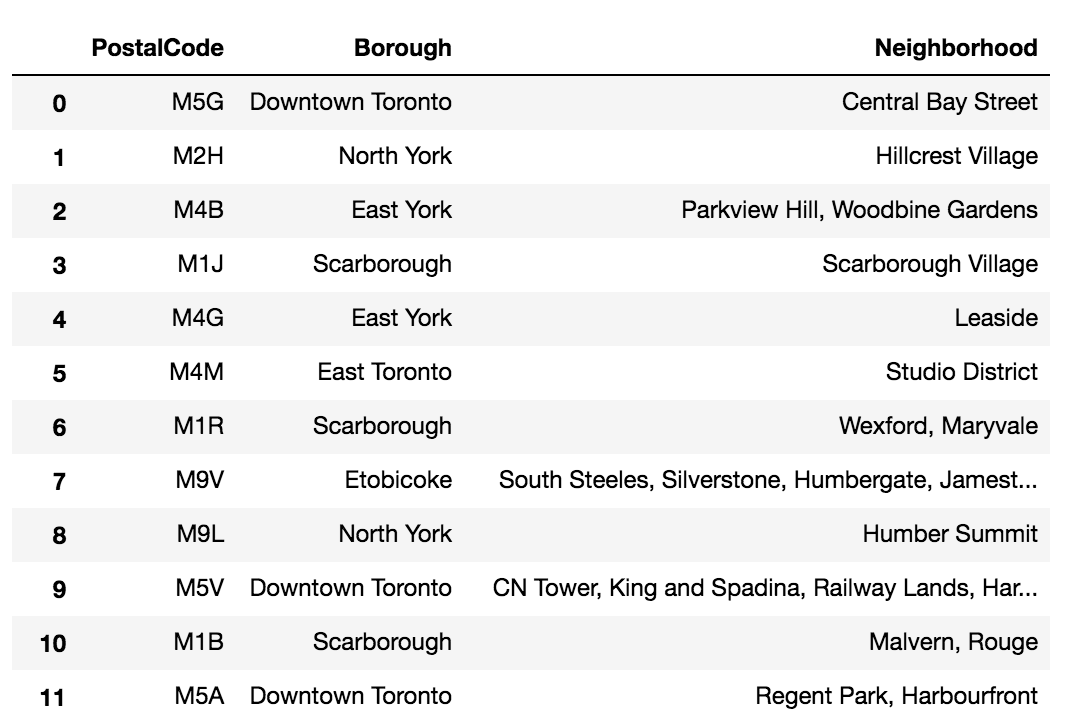

3. To create the above dataframe:

- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
- If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough.
- Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
- In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

4. Submit a link to your Notebook on your Github repository. (10 marks)

Note: There are different website scraping libraries and packages in Python. For scraping the above table, you can simply use pandas to read the table into a pandas dataframe.

Another way, which would help to learn for more complicated cases of web scraping is using the BeautifulSoup package. Here is the package's main documentation page: http://beautiful-soup-4.readthedocs.io/en/latest/

Use pandas, or the BeautifulSoup package, or any other way you are comfortable with to transform the data in the table on the Wikipedia page into the above pandas dataframe.

## ---------- Section 1, Answer ----------

In [2]:
# import libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests

In [28]:
# get data from Wikipedia link
wiki_link='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
raw_wiki= requests.get(wiki_link).text

In [44]:
# use BeautifulSoup
soup_wiki = BeautifulSoup(raw_wiki,'lxml')

In [52]:
# store data from the HTML page into a list
wiki_data = []
wiki_col = []
wiki_table = soup_wiki.find(class_='wikitable')

for index, tr in enumerate(wiki_table.find_all('tr')):
    section = []
    for td in tr.find_all(['th','td']):
        section.append(td.text.rstrip())
        
    # first row is headers
    if (index == 0):
        col = section
    else:
        wiki_data.append(section)

# convert list to dataframe
wiki_df = pd.DataFrame(data = wiki_data,columns = col)
wiki_df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [53]:
# From instructions: "Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned."

# remove rows with 'Not assigned' in the Borough column
wiki_df = wiki_df[wiki_df['Borough'] != 'Not assigned']
wiki_df.head()

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [54]:
# From instructions: "More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page,
# you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined
# into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

# remove duplicates
wiki_df = wiki_df.drop_duplicates()

# combine Neighbourhoods with same Postal Code into one row, with the Neighbourhoods separated with a comma
wiki_df["Neighbourhood"] = wiki_df.groupby("Postal Code")["Neighbourhood"].transform(lambda neigh: ', '.join(neigh))

# reset the index to start at zero
wiki_df.reset_index(inplace=True,drop=True)

wiki_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [55]:
# From instructions: "If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough."

# for cells with a 'Not assigned' Neighbourhood, make the Neighbourhood the same as the Borough
wiki_df['Neighbourhood'].replace("Not assigned", wiki_df["Borough"],inplace=True)
wiki_df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [56]:
# From instructions: "In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe."
wiki_df.shape

(103, 3)

### Note: It is my understanding that the table does not need to be in the same order as the example one shown in the instructions

## ---------- Section 2, Instructions ----------

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In an older version of this course, we were leveraging the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. However, recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, so we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. Taking postal code M5G as an example, your code would look something like this:

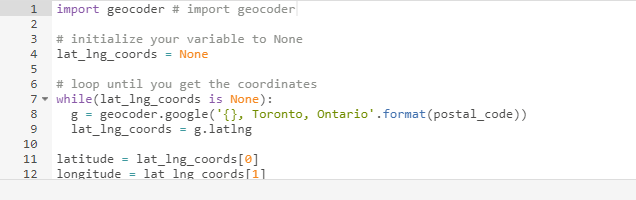

Given that this package can be very unreliable, in case you are not able to get the geographical coordinates of the neighborhoods using the Geocoder package, here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

Use the Geocoder package or the csv file to create the following dataframe:

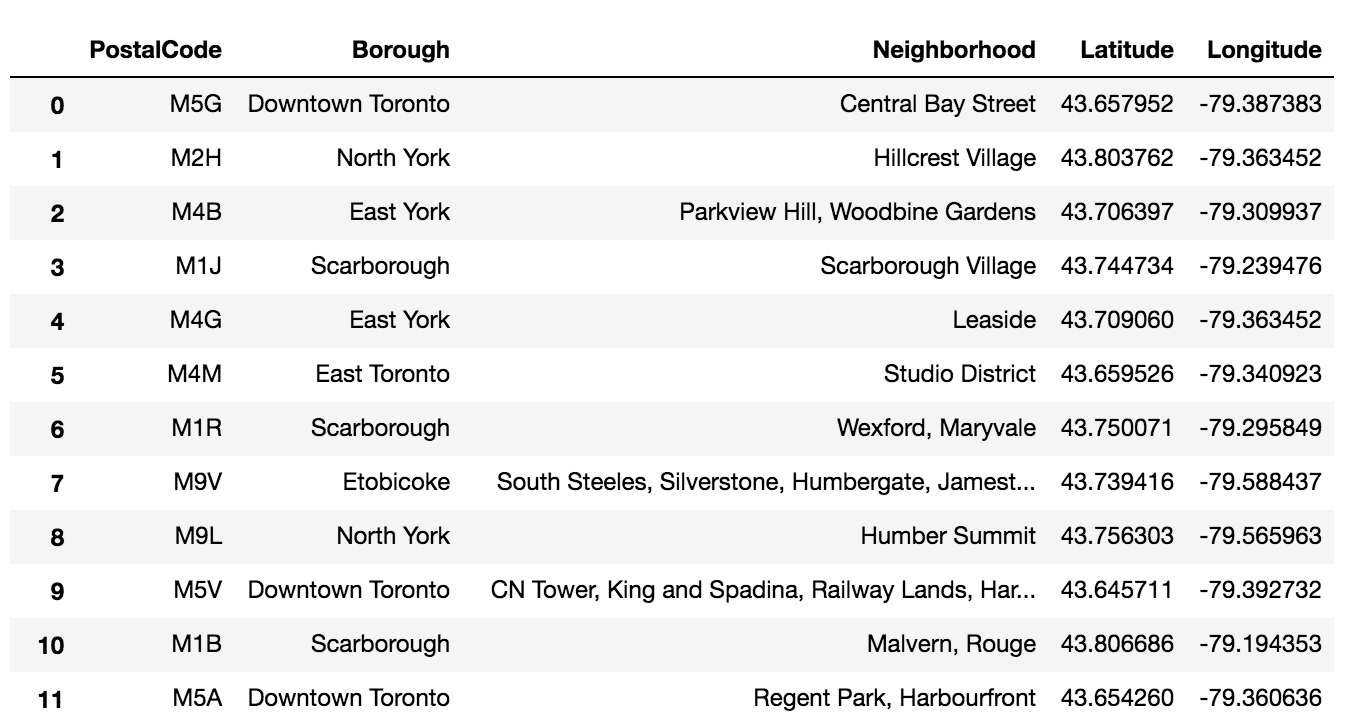

Important Note: There is a limit on how many times you can call geocoder.google function. It is 2500 times per day. This should be way more than enough for you to get acquainted with the package and to use it to get the geographical coordinates of the neighborhoods in the Toronto.

## ---------- Section 2, Answer ----------

### Due to the Geocoder Python Package being somewhat inconsistent, I've decided to use the provided .csv file instead.

In [60]:
# use provided csv link to obtain coordinates
csv_link = 'http://cocl.us/Geospatial_data'
df_coordinates = pd.read_csv(csv_link)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [61]:
# combine dataframes
df_toronto = pd.merge(wiki_df, df_coordinates, how='left', left_on = 'Postal Code', right_on = 'Postal Code')
df_toronto.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


## ---------- Section 3, Instructions ----------

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:

1. to add enough Markdown cells to explain what you decided to do and to report any observations you make.
2. to generate maps to visualize your neighborhoods and how they cluster together.

## ---------- Section 3, Answer ----------

In [67]:
# import Nominatim (converts address to latitude and longitude)
from geopy.geocoders import Nominatim

# get the corrdinates of Toronto, Canada
address = "Toronto, ON"
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of',address,'are (',latitude,', ',longitude,').')

The geograpical coordinates of Toronto, ON are ( 43.6534817 ,  -79.3839347 ).


In [69]:
# install and import folium (for map)
!pip install folium
import folium

     |████████████████████████████████| 93 kB 3.0 MB/s  eta 0:00:01


In [71]:
# create map of Toronto
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=10)
toronto_map

### Note: I've been told the maps might not appear in Github, so here's a partial screen capture of it:
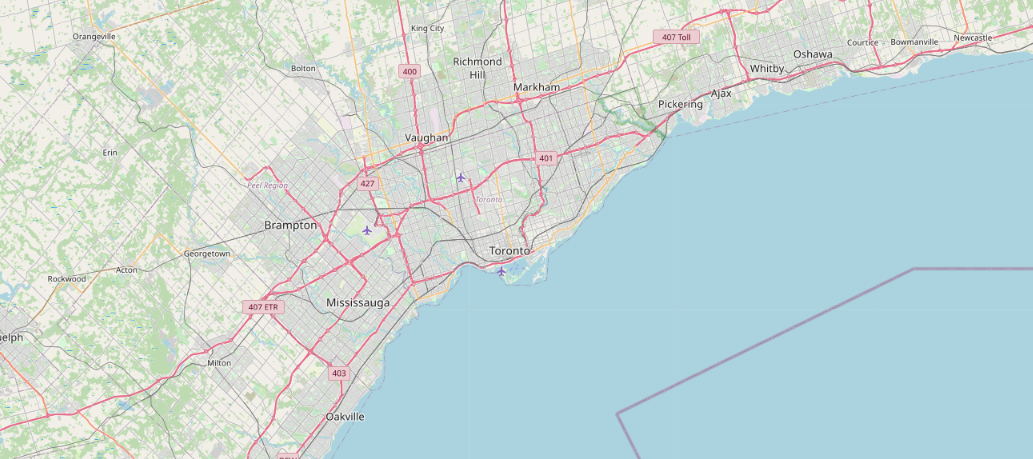

In [73]:
# mark locations on the map for each latitude and longitude listed in the table obtained from Section 2

# for each row in the dataframe...
for lat, long, borough, neighbourhood in zip(
        df_toronto['Latitude'], 
        df_toronto['Longitude'], 
        df_toronto['Borough'], 
        df_toronto['Neighbourhood']):
    # format label as "neighbourhood, borough" and make it a pop up
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    # make a green circle for each point
    folium.CircleMarker(
        [lat, long],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='#1FDD07',
        fill_opacity=0.8,
        parse_html=False).add_to(toronto_map)  

toronto_map

### Note: I've been told the maps might not appear in Github, so here's a partial screen capture of it:
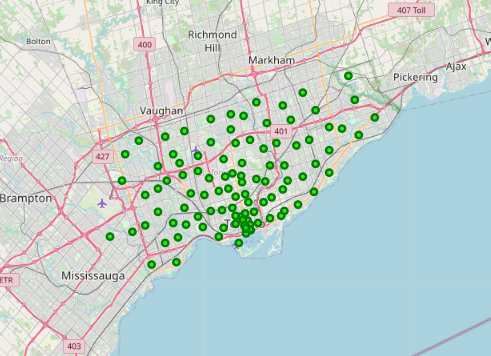

In [75]:
# From the instructions: "You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you."

# use only the boroughs that contain the word Toronto (drop all other rows)
df_toronto_partial = df_toronto[df_toronto['Borough'].str.contains("Toronto")].reset_index(drop=True)
df_toronto_partial.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


In [77]:
# use the same method to mark the locations on the map, but this time, only for the boroughs with "Toronto" in them
map_toronto_partial = folium.Map(location=[latitude, longitude], zoom_start=12)
# for each row in the dataframe...
for lat, long, borough, neighbourhood in zip(
        df_toronto_partial['Latitude'], 
        df_toronto_partial['Longitude'], 
        df_toronto_partial['Borough'], 
        df_toronto_partial['Neighbourhood']):
    # format label as "neighbourhood, borough" and make it a pop up
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    # make a green circle for each point
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#1FDD07',
        fill_opacity=0.8,
        parse_html=False).add_to(map_toronto_partial)  

map_toronto_partial

### Note: I've been told the maps might not appear in Github, so here's a partial screen capture of it:
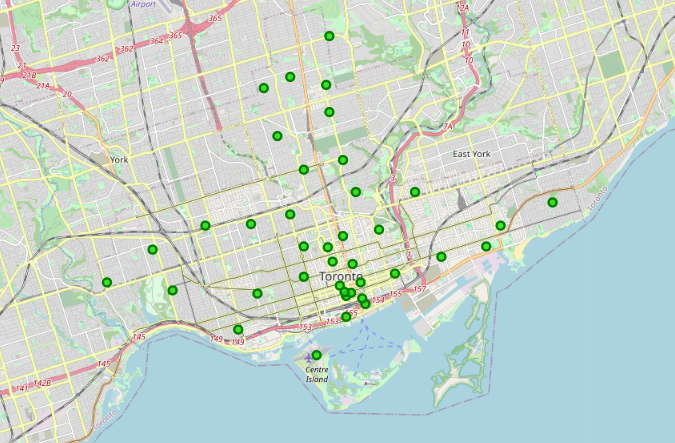

## NOTE: I remember reading that we're not technically supposed to post/share Foursquare credentials publically, so in the Github repository, I will be replacing these with 'REDACTED'

In [89]:
# set client ID, client secret, and version (these will be replaced with 'REDACTED' on the Github repository)
CLIENT_ID = 'REDACTED'
CLIENT_SECRET = 'REDACTED'
ACCESS_TOKEN = 'ML1ZZREDK4RKHU41ECCMZDDZQLYF3Q4ZOE02RMNU44HECCVY'
VERSION = '20180604'

In [90]:
# look at the first neighborhood in the condensed dataframe
neigh_name = df_toronto_partial.loc[0, 'Neighbourhood']
print('The name of the first neighborhood(s) in the condensed dataframe is/are',neigh_name,'.')

The name of the first neighborhood(s) in the condensed dataframe is/are Regent Park, Harbourfront .


In [91]:
# get the location of the first neighborhood in the condensed dataframe
neigh_lat = df_toronto_partial.loc[0, 'Latitude']
neigh_long = df_toronto_partial.loc[0, 'Longitude']
print('The geographical coordinates of',neigh_name,'are (',neigh_lat,',',neigh_long,').')

The geographical coordinates of Regent Park, Harbourfront are ( 43.6542599 , -79.3606359 ).


In [110]:
# get the top 100 venues within a 500 meter radius of the first neighborhood(s) in the condensed dataframe
limit = 100
radius = 500
search_query = ''
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID,
    CLIENT_SECRET,
    neigh_lat,
    neigh_long,
    ACCESS_TOKEN,
    VERSION,
    search_query,
    radius,
    limit)

# put the results in a json file
results = requests.get(url).json()

In [111]:
# define a function to get the category of these venues
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [102]:
# import json_normalize
from pandas import json_normalize

In [113]:
venues = results['response']['venues']

close_venues = json_normalize(venues)

# filter columns
filt_columns = ['name', 'categories', 'location.lat', 'location.lng']
close_venues = close_venues.loc[:, filt_columns]

# filter the category for each row
close_venues['categories'] = close_venues.apply(get_category_type, axis=1)

# clean columns
close_venues.columns = [col.split(".")[-1] for col in close_venues.columns]

close_venues.head()

,name,categories,lat,lng
0,Oldtown Bodega,Café,43.653966,-79.360752
1,Sackville Playground,Park,43.654656,-79.359871
2,Tandem Coffee,Coffee Shop,43.653559,-79.361809
3,Cam's Auto Service,Automotive Shop,43.654195,-79.360545
4,Body Blitz Spa East,Spa,43.654735,-79.359874


In [133]:
# define a function so we can repeat the above process to find the top 100 venues for every neighborhood in the condensed dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            neigh_lat,
            neigh_long,
            ACCESS_TOKEN,
            VERSION,
            search_query,
            radius,
            limit)

        # put the results in a json file
        results = requests.get(url).json()["response"]['venues']
        
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories']) for v in results])

    close_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    close_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(close_venues)

In [137]:
# create a dataframe for the top 100 venues for each neighborhood in the condensed list
toronto_partial_venues = getNearbyVenues(names=df_toronto_partial['Neighbourhood'],
                                   latitudes=df_toronto_partial['Latitude'],
                                   longitudes=df_toronto_partial['Longitude']
                                  )
toronto_partial_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Oldtown Bodega,43.653966,-79.360752,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C..."
1,"Regent Park, Harbourfront",43.65426,-79.360636,Sackville Playground,43.654656,-79.359871,"[{'id': '4bf58dd8d48988d163941735', 'name': 'P..."
2,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C..."
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cam's Auto Service,43.654195,-79.360545,"[{'id': '4bf58dd8d48988d124951735', 'name': 'A..."
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,"[{'id': '4bf58dd8d48988d1ed941735', 'name': 'S..."


In [142]:
# define a function to get the category of these venues
def get_category_type_two(row):
    try:
        categories_list = row['Venue Category']
    except:
        categories_list = row['venue.Venue Category']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [146]:
# filter the category for each row
toronto_partial_venues_filt = toronto_partial_venues
toronto_partial_venues_filt['Venue Category'] = toronto_partial_venues_filt.apply(get_category_type_two, axis=1)

toronto_partial_venues_filt.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Oldtown Bodega,43.653966,-79.360752,Café
1,"Regent Park, Harbourfront",43.65426,-79.360636,Sackville Playground,43.654656,-79.359871,Park
2,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cam's Auto Service,43.654195,-79.360545,Automotive Shop
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [147]:
# check how many venues were returned for each neighborhood
toronto_partial_venues_filt.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,100,100,100,100,100,92
"Brockton, Parkdale Village, Exhibition Place",100,100,100,100,100,92
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,92
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",100,100,100,100,100,92
Central Bay Street,100,100,100,100,100,92
Christie,100,100,100,100,100,92
Church and Wellesley,100,100,100,100,100,92
"Commerce Court, Victoria Hotel",100,100,100,100,100,92
Davisville,100,100,100,100,100,92


In [150]:
# determine how many unique categories there are in all returned venues
print('There are',len(toronto_partial_venues_filt['Venue Category'].unique()),'unique categories.')

There are 56 unique categories.


In [151]:
# analyze each neighborhood

# one hot encoding
toronto_partial_onehot = pd.get_dummies(toronto_partial_venues_filt[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_partial_onehot['Neighborhood'] = toronto_partial_venues_filt['Neighborhood'] 

# move neighborhood column to the first column
fix_col = [toronto_partial_onehot.columns[-1]] + list(toronto_partial_onehot.columns[:-1])
toronto_partial_onehot = toronto_partial_onehot[fix_col]

toronto_partial_onehot.head()

,Neighborhood,Advertising Agency,Art Gallery,Arts & Crafts Store,Assisted Living,Auto Dealership,Automotive Shop,Bakery,Bar,Bed & Breakfast,...,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Salon / Barbershop,Sandwich Place,Sculpture Garden,Spa,Sporting Goods Shop,Street Art,Trade School
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [153]:
# group rows by neighborhood, by taking the mean of the frequency of occurrence of each category
toronto_partial_grouped = toronto_partial_onehot.groupby('Neighborhood').mean().reset_index()
toronto_partial_grouped.head()

,Neighborhood,Advertising Agency,Art Gallery,Arts & Crafts Store,Assisted Living,Auto Dealership,Automotive Shop,Bakery,Bar,Bed & Breakfast,...,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Salon / Barbershop,Sandwich Place,Sculpture Garden,Spa,Sporting Goods Shop,Street Art,Trade School
0,Berczy Park,0.01,0.03,0.01,0.02,0.02,0.08,0.01,0.01,0.00,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
1,"Brockton, Parkdale Village, Exhibition Place",0.01,0.03,0.01,0.02,0.02,0.08,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01
2,"Business reply mail Processing Centre, South C...",0.01,0.03,0.01,0.02,0.02,0.08,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.01
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.01,0.03,0.01,0.02,0.02,0.08,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
4,Central Bay Street,0.01,0.03,0.01,0.02,0.02,0.08,0.01,0.01,0.00,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [154]:
# define function that returns the most common venues
def most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [155]:
# check the 10 most common venues in each neighborhood
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# make columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_partial_grouped['Neighborhood']

for ind in np.arange(toronto_partial_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = most_common_venues(toronto_partial_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
1,"Brockton, Parkdale Village, Exhibition Place",Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
2,"Business reply mail Processing Centre, South C...",Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
3,"CN Tower, King and Spadina, Railway Lands, Har...",Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
4,Central Bay Street,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run


In [157]:
# import k-means
from sklearn.cluster import KMeans

In [158]:
# run k means to cluster the neighborhood into 5 clusters

kclusters = 5
toronto_partial_grouped_clustering = toronto_partial_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_partial_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:5: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.


array([2, 0, 0, 3, 2, 2, 0, 0, 2, 3], dtype=int32)

In [164]:
# create dataframe that includes the clusters and top 10 venues for each neighborhood

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# need to rename "neighbourhoods" from df_toronto_partial to "neighborhoods", so they match
df_toronto_partial_two = df_toronto_partial.rename(columns={'Neighbourhood': 'Neighborhood'})

toronto_partial_merged = df_toronto_partial_two
toronto_partial_merged = toronto_partial_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_partial_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop


In [166]:
# import colors (for the map)
import matplotlib.cm as cm
import matplotlib.colors as colors

In [168]:
# create a map (same process as before), showing the resulting clusters

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        toronto_partial_merged['Latitude'], 
        toronto_partial_merged['Longitude'], 
        toronto_partial_merged['Neighborhood'], 
        toronto_partial_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

### Note: I've been told that the maps may not appear in Github, so here's a partial screen capture of it:
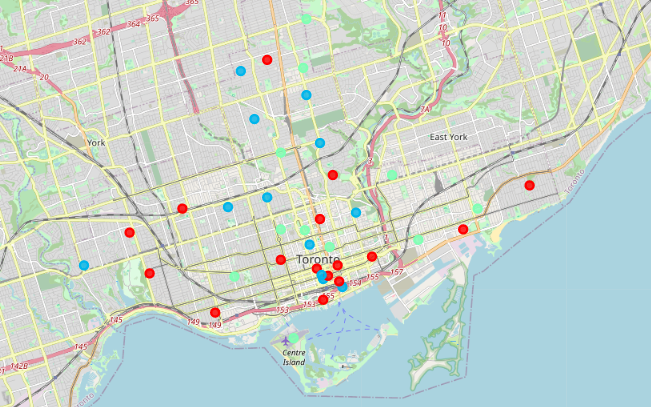

In [169]:
# Examine each cluster
# Cluster 1
toronto_partial_merged.loc[toronto_partial_merged['Cluster Labels'] == 0, toronto_partial_merged.columns[[1] + list(range(5, toronto_partial_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Downtown Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
3,Downtown Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
4,East Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
8,Downtown Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
9,West Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
10,Downtown Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
14,West Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
16,Downtown Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
22,West Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop
23,Central Toronto,0,Office,Automotive Shop,Building,Furniture / Home Store,Coffee Shop,Italian Restaurant,Food Truck,Art Gallery,Park,Flower Shop


In [171]:
# Cluster 2
toronto_partial_merged.loc[toronto_partial_merged['Cluster Labels'] == 2, toronto_partial_merged.columns[[1] + list(range(5, toronto_partial_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Downtown Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
6,Downtown Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
7,Downtown Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
13,Downtown Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
19,Central Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
21,Central Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
24,Central Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
26,Central Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
28,West Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run
29,Central Toronto,2,Office,Automotive Shop,Furniture / Home Store,Food Truck,Building,Coffee Shop,Italian Restaurant,Art Gallery,Flower Shop,Dog Run


In [172]:
# Cluster 3
toronto_partial_merged.loc[toronto_partial_merged['Cluster Labels'] == 3, toronto_partial_merged.columns[[1] + list(range(5, toronto_partial_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Downtown Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
2,Downtown Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
11,West Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
12,East Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
15,East Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
17,East Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
18,Central Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
20,Central Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
27,Downtown Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park
31,Central Toronto,3,Office,Automotive Shop,Building,Coffee Shop,Italian Restaurant,Food Truck,Furniture / Home Store,Art Gallery,Light Rail Station,Park


## Observations:
- The clustering resulted in three main clusters (two of the five were empty)
- All clusters had office and automotive shop as their 1st and 2nd most common venues, meaning the 3rd most common (and onwards) are the ones that actually defined where the clusters broke up